Epoch [1/200] | Train Loss: 0.532196 | Val Loss: 0.552516
Epoch [2/200] | Train Loss: 0.337836 | Val Loss: 0.300236
Epoch [3/200] | Train Loss: 0.158565 | Val Loss: 0.195147
Epoch [4/200] | Train Loss: 0.116924 | Val Loss: 0.156010
Epoch [5/200] | Train Loss: 0.103117 | Val Loss: 0.144096
Epoch [6/200] | Train Loss: 0.096116 | Val Loss: 0.136800
Epoch [7/200] | Train Loss: 0.092160 | Val Loss: 0.134753
Epoch [8/200] | Train Loss: 0.085870 | Val Loss: 0.134804
Epoch [9/200] | Train Loss: 0.083418 | Val Loss: 0.134709
Epoch [10/200] | Train Loss: 0.081354 | Val Loss: 0.130909
Epoch [11/200] | Train Loss: 0.080853 | Val Loss: 0.127974
Epoch [12/200] | Train Loss: 0.078683 | Val Loss: 0.124273
Epoch [13/200] | Train Loss: 0.082968 | Val Loss: 0.122025
Epoch [14/200] | Train Loss: 0.085502 | Val Loss: 0.124871
Epoch [15/200] | Train Loss: 0.076139 | Val Loss: 0.121515
Epoch [16/200] | Train Loss: 0.079749 | Val Loss: 0.117254
Epoch [17/200] | Train Loss: 0.076074 | Val Loss: 0.119587
Epoch 

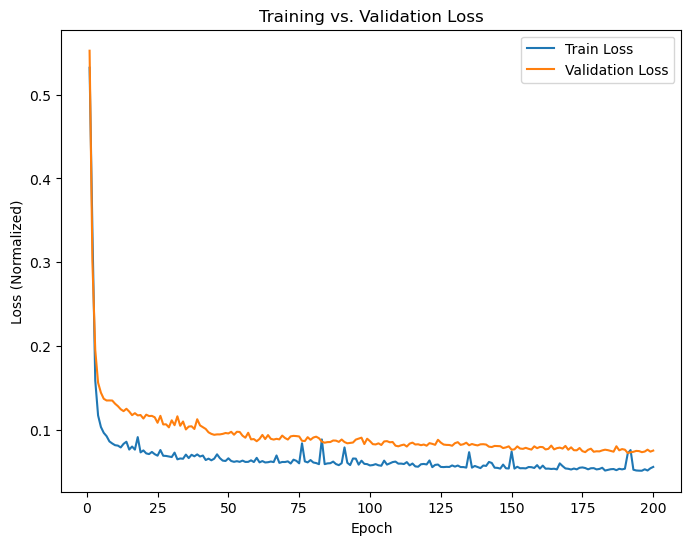

Sample	Predicted MPG	True MPG
--------------------------------------
13	20.68		19.20
8	19.41		18.00
44	24.57		23.00
55	25.44		27.00
50	14.71		15.00
47	36.39		37.00
11	29.71		29.50
23	20.22		19.00
2	28.66		26.60
3	22.86		24.00


In [72]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import requests

# Import MLP components from your mlp.py module.
from mlp import (
    Layer, MultilayerPerceptron,
    SquaredError, CrossEntropy,
    Tanh, Linear, 
    Relu, Softplus, Mish
)

def load_auto_mpg():
    """
    Downloads and processes the Auto MPG dataset from the UCI repository.
    
    Returns:
        X (np.ndarray): Normalized feature array of shape (n_samples, 7)
        y (np.ndarray): Normalized target MPG values of shape (n_samples, 1)
        y_mean (np.ndarray): Mean of original y values (for inverse normalization)
        y_std (np.ndarray): Standard deviation of original y values (for inverse normalization)
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"Failed to download dataset from {url}. Status code: {r.status_code}")
    
    lines = r.text.strip().split('\n')
    x_list = []
    y_list = []
    for line in lines:
        parts = line.split()
        if len(parts) < 8:
            continue
        mpg_str = parts[0]
        # Skip rows with missing horsepower ('?')
        if '?' in parts[3]:
            continue

        try:
            mpg = float(mpg_str)
            # Extract features: cylinders, displacement, horsepower, weight, acceleration, model year, origin
            features = list(map(float, [parts[1], parts[2], parts[3], parts[4], parts[5], parts[6], parts[7]]))
        except ValueError:
            continue

        x_list.append(features)
        y_list.append(mpg)

    # Convert lists to numpy arrays.
    X = np.array(x_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32).reshape(-1, 1)

    # Normalize features: subtract mean and divide by standard deviation.
    X_mean = X.mean(axis=0, keepdims=True)
    X_std  = X.std(axis=0, keepdims=True) + 1e-9  # small constant to prevent division by zero
    X = (X - X_mean) / X_std

    # Normalize targets and store original mean and std for later inverse transformation.
    y_mean = y.mean(axis=0, keepdims=True)
    y_std  = y.std(axis=0, keepdims=True) + 1e-9
    y_norm = (y - y_mean) / y_std

    return X, y_norm, y_mean, y_std

def main():
    # 1) Download and load the dataset.
    X, y, y_mean, y_std = load_auto_mpg()
    n_samples = X.shape[0]

    # 2) Shuffle the dataset and split into 70% training, 15% validation, and 15% testing.
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    train_end = int(0.70 * n_samples)
    val_end   = int(0.85 * n_samples)
    train_x, train_y = X[:train_end], y[:train_end]
    val_x,   val_y   = X[train_end:val_end], y[train_end:val_end]
    test_x,  test_y  = X[val_end:], y[val_end:]

    # 3) Build the MLP for regression.
    # Architecture: 7 input features -> 16 hidden neurons with Tanh activation -> 1 output with Linear activation.
    layers = [
        Layer(fan_in=7, fan_out=16, activation_function=Tanh()),
        Layer(fan_in=16, fan_out=1, activation_function=Linear())
    ]
    mlp = MultilayerPerceptron(layers)

    # 4) Use the SquaredError loss function (MSE).
    loss_func = SquaredError()

    # 5) Define training parameters.
    learning_rate = 1e-3
    batch_size    = 16
    epochs        = 200

    # 6) Train the model while printing training and validation loss at each epoch.
    train_losses, val_losses = mlp.train(
        train_x, train_y,
        val_x,   val_y,
        loss_func=loss_func,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs
    )

    # 7) Evaluate the model on the test set (disable dropout by setting training=False).
    pred_test = mlp.forward(test_x, training=True)
    test_loss_norm = loss_func.loss(test_y, pred_test)
    print(f"\nTest Loss on Normalized Data (MSE-like): {test_loss_norm:.4f}")

    # 8) Inverse transform predictions and test targets to the original MPG scale.
    pred_test_actual = pred_test * y_std + y_mean
    test_y_actual    = test_y * y_std + y_mean

    # Compute evaluation metrics on actual MPG values.
    errors_squared = [(pred[0] - true[0])**2 for pred, true in zip(pred_test_actual, test_y_actual)]
    mse_manual = sum(errors_squared) / len(errors_squared)

    absolute_errors = [abs(pred[0] - true[0]) for pred, true in zip(pred_test_actual, test_y_actual)]
    mae_manual = sum(absolute_errors) / len(absolute_errors)

    print("\nEvaluation Metrics (Actual MPG):")
    print(f"Mean Squared Error (MSE): {mse_manual:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_manual:.4f}\n")

    # 9) Plot training and validation loss curves.
    plt.figure(figsize=(8,6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Normalized)')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.show()

    # 10) Print a table of sample predictions vs. true MPG (denormalized).
    sample_indices = np.random.choice(test_x.shape[0], 10, replace=False)
    print("Sample\tPredicted MPG\tTrue MPG")
    print("--------------------------------------")
    for idx in sample_indices:
        print(f"{idx}\t{pred_test_actual[idx,0]:.2f}\t\t{test_y_actual[idx,0]:.2f}")

if __name__ == "__main__":
    main()
